In [1]:
import os.path
from os import path
import requests
import tarfile
import shutil

In [2]:
PATH_TO_RESOURCES = "../resources"

## Récupération des ressources

**param force** : 1 si l'on veut télécharger la donnée m

1. Controlle l'existence d'un dossier de **resources** situé à la racine du projet
2. Si ce dossier existe et que **force == 0** alors il n'y a rien à faire
3. Sinon, le dossier est crée, l'archive est téléchargée et décompréssée puis supprimée.

In [3]:
# Check if a local resources file exists.
# If not or force=True, creates the files and uploads data.
def init_resources(force = False):
    PATH_TO_RESOURCES = "../resources"
    
    if (path.exists(PATH_TO_RESOURCES) and path.isdir(PATH_TO_RESOURCES)):
        if not force:
            print("Folder 'resources' found.")
            return
        else:
            shutil.rmtree(PATH_TO_RESOURCES)
    
    # Create folder
    os.mkdir(PATH_TO_RESOURCES)
    print("[1/4] Folder '../resources' created.")
    
    # Download data
    url_data = 'https://www.lrde.epita.fr/~jchazalo/SHARE/dobble-symbols-dataset-train.tar.gz'
    url_dobble_img = 'https://boardgamereview.co.uk/wp-content/uploads/2020/02/Dobble-cards-pile-1.png'
    TAR_PATH = os.path.join(PATH_TO_RESOURCES, 'dobble-symbols-dataset-train.tar.gz')
    IMG_PATH = os.path.join(PATH_TO_RESOURCES, 'dobble_ref.png')
    response = requests.get(url_data, stream=True)
    if response.status_code == 200:
        with open(TAR_PATH, 'wb') as f:
            f.write(response.raw.read())
    response = requests.get(url_dobble_img, stream=True)
    if response.status_code == 200:
        with open(IMG_PATH, 'wb') as f:
            f.write(response.raw.read())
            print("[2/4] Resources files uploaded.")
    
    # Extract from tar
    tar = tarfile.open(TAR_PATH)
    tar.extractall(PATH_TO_RESOURCES) # specify which folder to extract to
    tar.close()
    print("[3/4] Resources files extracted.")
    
    # Delete dowloaded tar
    os.remove(TAR_PATH)
    print("[4/4] Tarball removed.")

In [4]:
init_resources(0)

Folder 'resources' found.


## Transformateurs

### Extraction de la zone d'intérêt
1. Récupération des données d'entrainement
2. Calcul des masques
3. Extraction des pixels à utiliser dans chaque image

#### Explications

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [6]:
symbol_files = !ls $PATH_TO_RESOURCES/**/c*.png  | sort
symbol_files

['../resources/train/01/c01_s00.png',
 '../resources/train/01/c04_s01.png',
 '../resources/train/01/c07_s03.png',
 '../resources/train/01/c30_s03.png',
 '../resources/train/01/c34_s03.png',
 '../resources/train/02/c01_s01.png',
 '../resources/train/02/c09_s00.png',
 '../resources/train/02/c14_s05.png',
 '../resources/train/02/c32_s00.png',
 '../resources/train/02/c53_s03.png',
 '../resources/train/03/c03_s04.png',
 '../resources/train/03/c37_s00.png',
 '../resources/train/03/c47_s00.png',
 '../resources/train/03/c50_s01.png',
 '../resources/train/03/c51_s01.png',
 '../resources/train/04/c01_s03.png',
 '../resources/train/04/c22_s05.png',
 '../resources/train/04/c31_s02.png',
 '../resources/train/04/c39_s02.png',
 '../resources/train/04/c46_s04.png',
 '../resources/train/05/c01_s04.png',
 '../resources/train/05/c12_s07.png',
 '../resources/train/05/c23_s01.png',
 '../resources/train/05/c29_s02.png',
 '../resources/train/05/c38_s03.png',
 '../resources/train/06/c01_s05.png',
 '../resourc

In [8]:
symbols = [cv2.cvtColor(cv2.imread(symbol_file), cv2.COLOR_BGR2RGB) for symbol_file in symbol_files]
len(symbols), symbols[0].shape, symbols[0].dtype

(285, (86, 179, 3), dtype('uint8'))

## Récupération des labels

In [19]:
import re
import numpy as np
from sklearn.model_selection import train_test_split

In [20]:
symbols_labels = np.array([re.search(".+/([0-9]{2})/.+\.png", symbol_file).group(1) for symbol_file in symbol_files])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(symbols, symbols_labels, test_size=0.2, stratify=symbols_labels)

## Moments

In [9]:
import cv2
from math import copysign, log10

## Moments

Parmi les différents moments, les Hu moments sont connus pour être invariants à la rotation. \
Cette caractéristique nous intéresse particulièrement étant donné que la rotation de symbols varie fortement. \
Nous allons utiliser opencv pour calculer les Hu moments.

In [10]:
def symbol2moments(symbol):
    # Convert to grayscale
    symbol_gray = cv2.cvtColor(symbol, cv2.COLOR_RGB2GRAY)

    # Calculate Moments
    moments = cv2.moments(symbol_gray)

    # Calculate Hu Moments
    huMoments = cv2.HuMoments(moments)

    # Log scale hu moments to have same order of magnitude
    for i in range(0,7):
        huMoments[i] = -1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i]))

    return huMoments

In [79]:
symbol_moments = np.array([symbol2moments(symbol) for symbol in symbols])
symbol_moments.shape, symbol_moments.dtype

((285, 7, 1), dtype('float64'))

Regardons à quoi ressemblent les moments d'un de nos symbols.

array([[  2.69681686],
       [  5.89445391],
       [ 10.10296226],
       [ 12.09465788],
       [-23.37631654],
       [ 15.06309074],
       [ 23.31584578]])

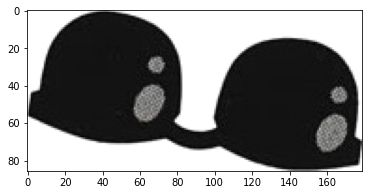

In [80]:
plt.imshow(symbols[0])
symbol_moments[0]

Ce n'est pas très parlant. 

Comparons ces valeurs avec celles d'un autre symbol.

array([[  3.03681422],
       [ 12.53091254],
       [ 15.12598102],
       [ 15.3195452 ],
       [-30.62973651],
       [-21.74507211],
       [ 30.7821091 ]])

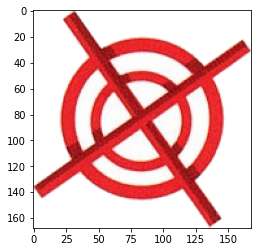

In [81]:
plt.imshow(symbols[5])
symbol_moments[5]

In [82]:
symbol_moments[5] - symbol_moments[0]

array([[  0.33999736],
       [  6.63645863],
       [  5.02301876],
       [  3.22488732],
       [ -7.25341997],
       [-36.80816285],
       [  7.46626333]])

On remarque effectivement une variation mais il est difficile d'avoir de l'évaluer telle quelle.

Comparons avec un autre exemple du même symbol.

array([[  3.07066746],
       [ 10.53409768],
       [ 15.98264544],
       [ 14.99342603],
       [ 30.74733839],
       [-20.50517012],
       [-30.55703847]])

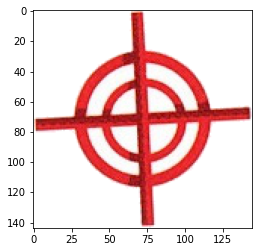

In [83]:
plt.imshow(symbols[6])
symbol_moments[6]

In [84]:
symbol_moments[5] - symbol_moments[6]

array([[-3.38532416e-02],
       [ 1.99681486e+00],
       [-8.56664425e-01],
       [ 3.26119176e-01],
       [-6.13770749e+01],
       [-1.23990199e+00],
       [ 6.13391476e+01]])

On remarque que les valeurs sont bien plus proches. 

On note aussi que les hu moments 5 et 7 sont proches à une variation de signe près. \
Voici les moments 5 et 7 des variations d'un même symbol :

In [97]:
symbol_moments[5:10, 4:7:2]

array([[[-30.62973651],
        [ 30.7821091 ]],

       [[ 30.74733839],
        [-30.55703847]],

       [[-30.50277026],
        [ 30.36628871]],

       [[ 31.96044101],
        [-32.39805958]],

       [[-30.75248148],
        [-30.78546544]]])

### Etape de pipeline

In [106]:
class HuMoments():
    def __init__(self):
        pass
        
    def fit(self, X, y=None, sample_weight=None):
        return self
    
    def transform(self, X, copy=None):
        X_gray = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in X]
        huMoments = []

        for i in range(len(X)):
            # Calculate Moments
            moments = cv2.moments(X_gray[i])
            # Calculate Hu Moments
            theseHuMoments = cv2.HuMoments(moments)

            # Log scale hu moments
            for i in range(0,7):
                theseHuMoments[i] = -1* copysign(1.0, theseHuMoments[i]) * log10(abs(theseHuMoments[i]))

            huMoments.append(theseHuMoments.reshape((7,)))

        return huMoments

## Classify test

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

### Démonstration

In [129]:
steps = [("hu moments", HuMoments()), ("Random Forest clf", RandomForestClassifier(n_estimators=100))]
pipeline = Pipeline(steps, verbose=True)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

[Pipeline] ........ (step 1 of 2) Processing hu moments, total=   0.0s
[Pipeline] . (step 2 of 2) Processing Random Forest clf, total=   0.1s


0.6491228070175439